<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Pyro - Bayesian Neural Net regression
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
import torch
import torch.nn as nn
# import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
# from pyro.nn import PyroModule, PyroParam, PyroSample, PyroModuleList
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine
from pyro.infer import Predictive

from bnn_model import BayesianMLP
from pyro_utils import AnnealingTrace_ELBO

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    # if using a GPU (CUDA) and num_chains > 1
    torch.multiprocessing.set_start_method('spawn', force=True)
else:    
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)

print(f"Using {device}")
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

torch.set_default_dtype(torch.float32)

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
0 : Generate synthetic data
</div>

In [4]:
# objective function, the one we wish to learn
def target_function(X:torch.Tensor) -> torch.Tensor:
    y = X * torch.sin(16*torch.pi*X)
    # y = torch.exp(2*X)
    return y

N_POINTS = 250

noise = torch.tensor([0.15])
X = torch.linspace(0.0, 1.0, steps=N_POINTS)
y = target_function(X) + torch.randn(N_POINTS)*noise

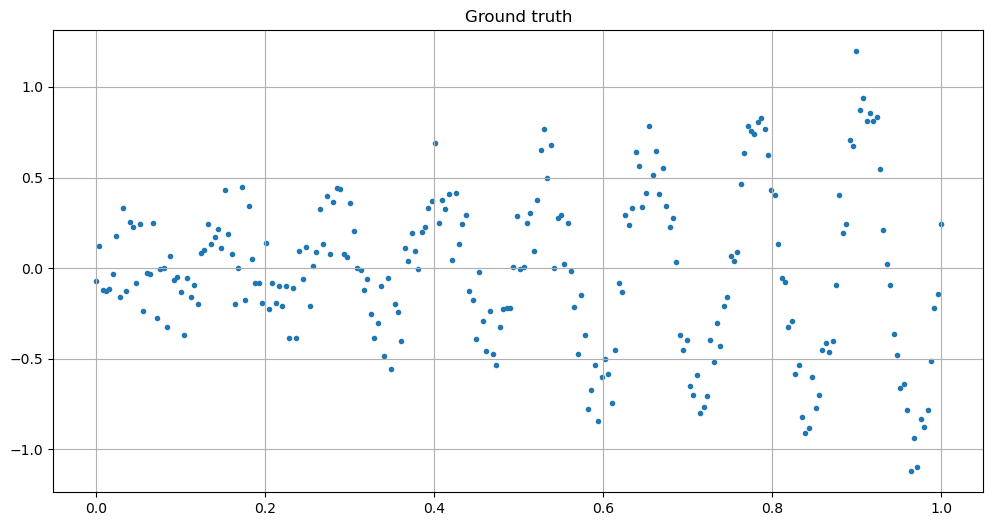

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X.cpu(),y.cpu(),label='ground truth', marker='.')
ax.grid()
ax.set_title(f'Ground truth')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
1 : Bayesian Neural Network with a Pyro model 
</div>

The idea is to consider all the network parameters (weights and biases) as random variables.

In [6]:
# # separate class definition to run mutli chain MCMC

# # Bayesian Neural Network
# class BayesianMLP(PyroModule):
#     """
#     The usual basic MLP class, but the Bayesian way
#     """
#     def __init__(self, n_layers=0, n_hidden_units=32, activation=nn.Tanh(), input_dim=1, output_dim=1, device='cpu', *args, **kwargs) -> None:
#         super().__init__(*args, **kwargs)
#         self.n_layers = n_layers
#         self.n_hidden_units = n_hidden_units
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.activation = activation
#         self.device = device    
        
#         # set tensors explicitly on the device for multi-chain
#         loc_prior = torch.tensor(0., device=self.device)
#         scale_prior = torch.tensor(1., device=self.device)
#         noise_loc = torch.tensor(-2.0, device=self.device)
#         noise_scale = torch.tensor(0.1, device=self.device)
        
#         self.layers = PyroModuleList([])
#         layer_input_dim = self.input_dim
#         for _ in range(self.n_layers+1):
#             bayesian_fc = PyroModule[nn.Linear](layer_input_dim, self.n_hidden_units)
#             bayesian_fc.weight = PyroSample(dist.Normal(loc_prior,scale_prior).expand(bayesian_fc.weight.shape).to_event(bayesian_fc.weight.dim()))
#             bayesian_fc.bias = PyroSample(dist.Normal(loc_prior, scale_prior).expand(bayesian_fc.bias.shape).to_event(bayesian_fc.bias.dim()))
#             self.layers.append(bayesian_fc)
#             layer_input_dim = self.n_hidden_units
            
#         # last layer
#         self.last_layer = PyroModule[nn.Linear](self.n_hidden_units, self.output_dim) 
#         self.last_layer.weight = PyroSample(dist.Normal(loc_prior,scale_prior).expand(self.last_layer.weight.shape).to_event(self.last_layer.weight.dim()))
#         self.last_layer.bias = PyroSample(dist.Normal(loc_prior,scale_prior).expand(self.last_layer.bias.shape).to_event(self.last_layer.bias.dim()))     
        
#         # noise term
#         self.log_sigma = PyroSample(dist.Normal(noise_loc,noise_scale))
        
#         # In Pyro, when you use PyroSample as an attribute of a PyroModule, 
#         # the attribute name itself (self.log_sigma in this case) becomes the name of the stochastic site in the model's trace. 
#         # Therefore, you should not pass the name as a string argument to PyroSample.   
        
#     def forward(self,x, y=None):
#         x = x.reshape(-1,1)
#         for layer in self.layers:
#             x = self.activation(layer(x))
#         mu = self.last_layer(x).squeeze()
        
#         sigma = torch.exp(self.log_sigma)
        
#         with pyro.plate("data", len(x)):
#             pyro.sample("observations", dist.Normal(mu, sigma), obs=y)
#         return mu
    
#     def __repr__(self):
#         msg = f'object MLP - input dim = {self.input_dim}, output_dim = {self.output_dim}, num layers = {self.n_layers}, hidden units = {self.n_hidden_units}\n'
#         for name, module in self.named_modules():
#             if isinstance(module, nn.Linear):
#                 msg += f"name = {name}, module = {module}\n"
    
#         return msg

In [7]:
model = BayesianMLP(n_layers=4, n_hidden_units=32, device=device)
print(model)

object MLP - input dim = 1, output_dim = 1, num layers = 4, hidden units = 32
name = layers.0, module = PyroLinear(in_features=1, out_features=32, bias=True)
name = layers.1, module = PyroLinear(in_features=32, out_features=32, bias=True)
name = layers.2, module = PyroLinear(in_features=32, out_features=32, bias=True)
name = layers.3, module = PyroLinear(in_features=32, out_features=32, bias=True)
name = layers.4, module = PyroLinear(in_features=32, out_features=32, bias=True)
name = last_layer, module = PyroLinear(in_features=32, out_features=1, bias=True)



In [8]:
# this returns the likelihood of y given X, with samples from initialized weights priors
print(model(X,y))

tensor([ 4.4002,  4.4770,  4.5470,  4.6109,  4.6693,  4.7226,  4.7715,  4.8165,
         4.8581,  4.8967,  4.9327,  4.9667,  4.9990,  5.0301,  5.0606,  5.0909,
         5.1218,  5.1537,  5.1876,  5.2239,  5.2634,  5.3068,  5.3544,  5.4066,
         5.4634,  5.5244,  5.5891,  5.6564,  5.7249,  5.7932,  5.8596,  5.9228,
         5.9816,  6.0357,  6.0852,  6.1309,  6.1741,  6.2163,  6.2592,  6.3043,
         6.3532,  6.4073,  6.4675,  6.5350,  6.6104,  6.6942,  6.7867,  6.8876,
         6.9965,  7.1127,  7.2351,  7.3627,  7.4946,  7.6302,  7.7691,  7.9111,
         8.0560,  8.2037,  8.3541,  8.5068,  8.6615,  8.8179,  8.9758,  9.1354,
         9.2968,  9.4604,  9.6266,  9.7963,  9.9700, 10.1484, 10.3320, 10.5209,
        10.7151, 10.9137, 11.1153, 11.3181, 11.5197, 11.7174, 11.9089, 12.0921,
        12.2656, 12.4287, 12.5815, 12.7247, 12.8595, 12.9874, 13.1099, 13.2284,
        13.3441, 13.4578, 13.5701, 13.6811, 13.7909, 13.8990, 14.0050, 14.1083,
        14.2083, 14.3045, 14.3961, 14.48

In [9]:
# this samples an output
y_hat = model(X)
print(y_hat)

tensor([-6.9403, -6.8835, -6.8151, -6.7319, -6.6303, -6.5064, -6.3574, -6.1823,
        -5.9839, -5.7706, -5.5547, -5.3484, -5.1580, -4.9830, -4.8203, -4.6702,
        -4.5375, -4.4279, -4.3449, -4.2892, -4.2592, -4.2522, -4.2640, -4.2890,
        -4.3189, -4.3435, -4.3508, -4.3285, -4.2652, -4.1522, -3.9849, -3.7644,
        -3.4986, -3.2015, -2.8907, -2.5830, -2.2912, -2.0224, -1.7786, -1.5583,
        -1.3586, -1.1759, -1.0068, -0.8486, -0.6992, -0.5568, -0.4206, -0.2901,
        -0.1653, -0.0465,  0.0658,  0.1710,  0.2685,  0.3580,  0.4392,  0.5121,
         0.5769,  0.6340,  0.6842,  0.7281,  0.7668,  0.8012,  0.8323,  0.8613,
         0.8893,  0.9174,  0.9467,  0.9781,  1.0125,  1.0508,  1.0938,  1.1419,
         1.1955,  1.2548,  1.3198,  1.3902,  1.4656,  1.5451,  1.6280,  1.7132,
         1.7995,  1.8855,  1.9701,  2.0519,  2.1297,  2.2027,  2.2698,  2.3304,
         2.3838,  2.4298,  2.4679,  2.4981,  2.5203,  2.5346,  2.5410,  2.5398,
         2.5313,  2.5159,  2.4940,  2.46

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
2 : Stochastic Variational Inference
</div>

In [ ]:
# CHOICE 1 : 
# here, the "auto" posterior
# q_phi_auto = AutoDiagonalNormal(model)

# CHOICE 2 :
# here, a custom posterior - basically a Gaussian posterior on weights and biases,
# with diagonal covariance. Nothing too fancy.
# def q_phi(model_instance):
# def q_phi(x, y=None):
def q_phi(x, y=None, kl_weight=1.0):
    """
    Custom posterior
    We define mean and standard dev parameters for each Gaussian posterior
    """
    # weights and biases of the model
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):

            # WEIGTHS
            # Get shape from the module's attribute
            weight_shape = module.weight.shape
            weight_dim = module.weight.dim()
            # Define variational parameters for the weight posterior
            weight_loc = pyro.param(f"{name}.weight_loc", torch.zeros(weight_shape))
            weight_scale = pyro.param(
                f"{name}.weight_scale", 
                torch.full(weight_shape, 0.1),
                constraint=constraints.positive
            )
            # posterior sample RV must match the model's stochastic site name
            # use poutine.scale for kl annealing
            with poutine.scale(scale=kl_weight):
                pyro.sample(
                    f"{name}.weight", 
                    dist.Normal(weight_loc, weight_scale)
                    .expand(weight_shape)
                    .to_event(weight_dim)
            )
            # BIAS
            if module.bias is not None:
                # shapes
                bias_shape = module.bias.shape
                bias_dim = module.bias.dim()
                # posterior parameters
                bias_loc = pyro.param(f"{name}.bias_loc", torch.zeros(bias_shape))
                bias_scale = pyro.param(
                    f"{name}.bias_scale", 
                    torch.full(bias_shape, 0.1),
                    constraint=constraints.positive
                )
                # bias posterior
                with poutine.scale(scale=kl_weight):
                    pyro.sample(
                        f"{name}.bias", 
                        dist.Normal(bias_loc, bias_scale)
                            .expand(bias_shape)
                            .to_event(bias_dim)
                    )
                
    # noise
    log_sigma_loc = pyro.param("log_sigma_loc", torch.tensor(0.0))
    log_sigma_scale = pyro.param(
        "log_sigma_scale", 
        torch.tensor(0.1), 
        constraint=constraints.positive
    )
    with poutine.scale(scale=kl_weight):
        pyro.sample("log_sigma", dist.Normal(log_sigma_loc, log_sigma_scale))

In [11]:
lr = 1e-2
optimizer = Adam({"lr" : lr})
n_epochs = 5000

K=5
elbo = Trace_ELBO(
    num_particles=K,
)

# SVI object (baseline Trace_ELBO to isolate error)
svi = SVI(
    model=model,
    guide=q_phi,
    optim=optimizer,
    loss=elbo
)

In [12]:
# Clear old parameters
pyro.clear_param_store()

# training parameters
training_losses = []
kl_weights = []
validation_losses = []
N = len(X)

# KL
KL_annealing_steps = n_epochs
KL_max_weight = 1.0

for step in range(n_epochs):
    
    # kl weight
    kl_weight = min(1.0, (step+1)/KL_annealing_steps) * KL_max_weight
    loss = svi.step(X,y, kl_weight=kl_weight)
    
    # perform evaluation only
    with torch.no_grad():
        eval_loss = svi.evaluate_loss(X, y)
    
    # log the results
    training_losses.append(loss/N)
    validation_losses.append(eval_loss/N)
    kl_weights.append(kl_weight)
    
    # report out
    print(f'Epoch {step+1:<6} / {n_epochs:<6} - loss = {loss:.3e} - kl weight = {kl_weight:.3e} - val loss = {eval_loss:.3e}')

Epoch 1      / 5000   - loss = 4.491e+03 - kl weight = 2.000e-04 - val loss = 8.286e+03
Epoch 2      / 5000   - loss = 4.417e+03 - kl weight = 4.000e-04 - val loss = 8.349e+03
Epoch 3      / 5000   - loss = 4.437e+03 - kl weight = 6.000e-04 - val loss = 8.401e+03
Epoch 4      / 5000   - loss = 4.445e+03 - kl weight = 8.000e-04 - val loss = 8.399e+03
Epoch 5      / 5000   - loss = 4.447e+03 - kl weight = 1.000e-03 - val loss = 8.418e+03
Epoch 6      / 5000   - loss = 4.414e+03 - kl weight = 1.200e-03 - val loss = 8.439e+03
Epoch 7      / 5000   - loss = 4.443e+03 - kl weight = 1.400e-03 - val loss = 8.481e+03
Epoch 8      / 5000   - loss = 4.428e+03 - kl weight = 1.600e-03 - val loss = 8.508e+03
Epoch 9      / 5000   - loss = 4.452e+03 - kl weight = 1.800e-03 - val loss = 8.501e+03
Epoch 10     / 5000   - loss = 4.401e+03 - kl weight = 2.000e-03 - val loss = 8.524e+03
Epoch 11     / 5000   - loss = 4.445e+03 - kl weight = 2.200e-03 - val loss = 8.555e+03
Epoch 12     / 5000   - loss = 4

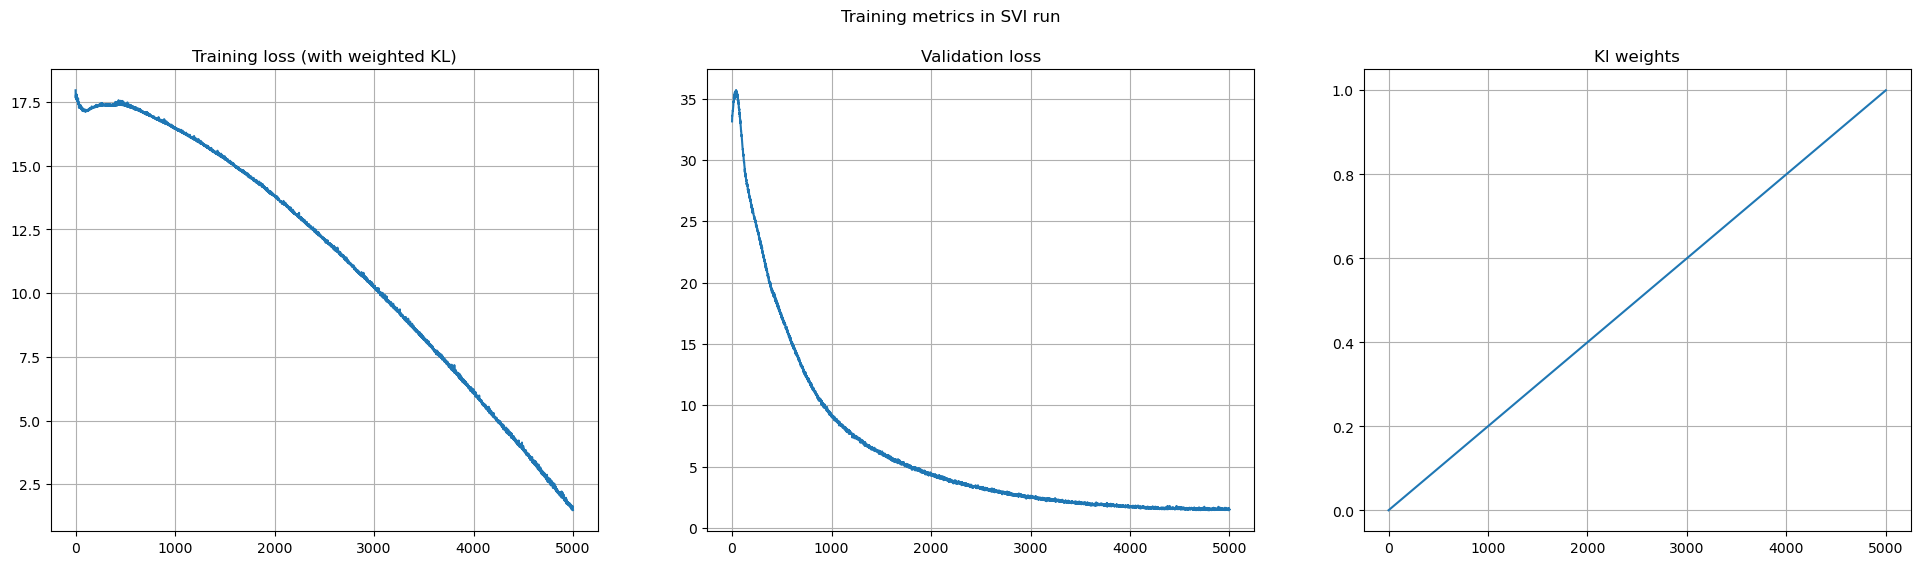

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

ax[0].plot(training_losses, label='training')
ax[0].set_title('Training loss (with weighted KL)')
ax[0].grid()
ax[1].plot(validation_losses, label='validation')
ax[1].set_title('Validation loss')
ax[1].grid()
ax[2].plot(kl_weights, label='KL weight')
ax[2].set_title('Kl weights')
ax[2].grid()
fig.suptitle(f'Training metrics in SVI run')
plt.show()

Reconstruction

In [14]:
# here, we want to draw samples from the trained model on known X's
import pyro.poutine as poutine

N_SAMPLES = 1000
N_POINTS = X.shape[0]

# place holder for predictions.
# at each point, draw samples of the predicted value.
y_preds = torch.zeros((N_POINTS, N_SAMPLES)).to(device)

for s in range(N_SAMPLES):
    # STEP 1: Trace the execution of the prediction guide.
    # The trace records the *value* of the sampled parameters (a, b, log_noise_std).
    # posterior_trace = poutine.trace(posterior_sampler).get_trace(X)
    # NB : here we used the q_phi guide/approximate posterior, and 
    #       did not write a specific simpler posterior sampler
    posterior_trace = poutine.trace(q_phi).get_trace(X)
    
    # STEP 2: Use the Replay Poutine on the Model.
    # This forces the Model to use the parameter values recorded in guide_trace.
    with poutine.replay(trace=posterior_trace):
        # STEP 3: Execute the Model to draw a prediction.
        # Calling model(X) with y=None tells the 'obs' site to draw a sample 
        # (the predicted y) using the replayed (fixed) parameters.
        predicted_y_vector = model(X, y=None) 
    
    # STEP 4: Store the resulting vector of predictions for all N_POINTS
    y_preds[:, s] = predicted_y_vector.squeeze()

print(f"Finished sampling {N_SAMPLES} predictive vectors.")

Finished sampling 1000 predictive vectors.


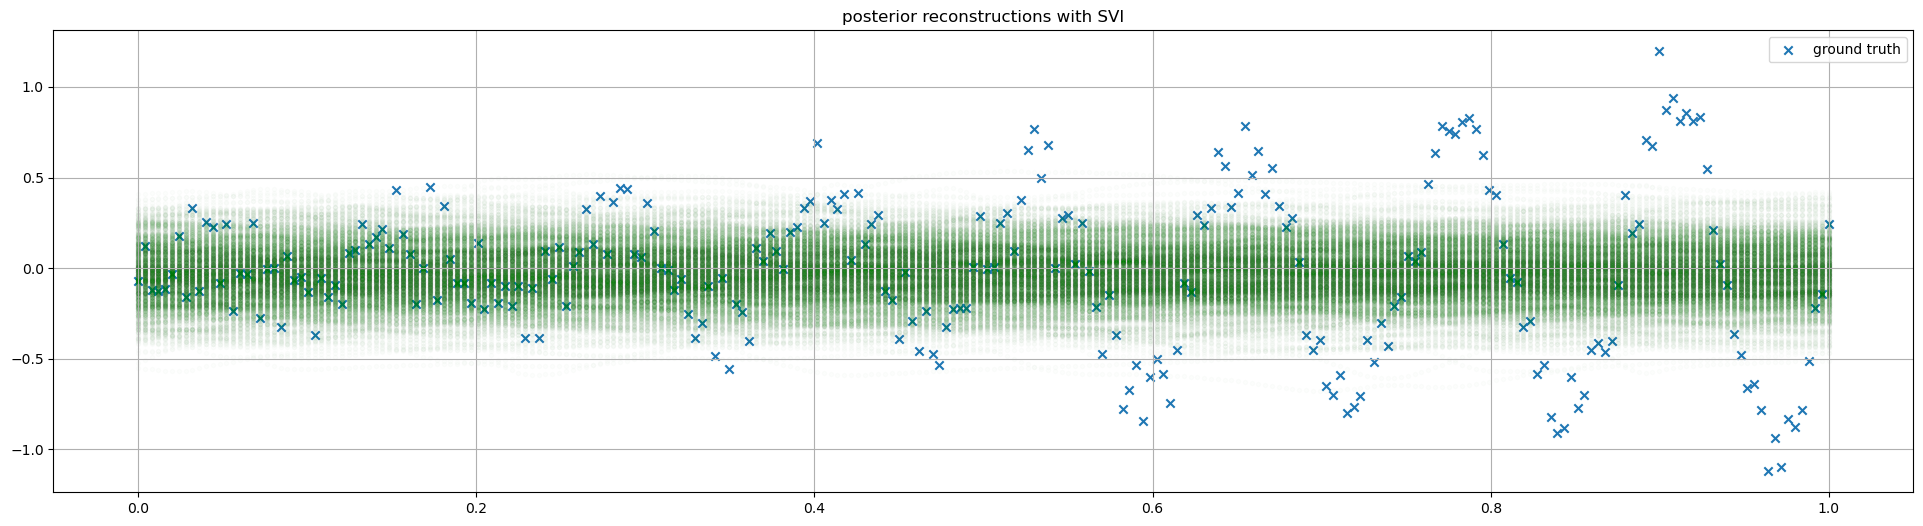

In [15]:
fig, ax = plt.subplots(figsize=(24,6))

ax.scatter(X.detach().cpu(),y.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior reconstructions with SVI')
for s in range(N_SAMPLES):
    ax.scatter(X.cpu(), y_preds[:,s].detach().cpu(), alpha=0.01, color='green', marker='.')
plt.show()

Forecast

In [16]:
X_new = torch.linspace(0.0,2.0, steps=N_POINTS)
y_new = target_function(X_new) + torch.randn(N_POINTS)*noise

# place holder for predictions.
# at each point, draw samples of the predicted value.
y_preds_new = torch.zeros((N_POINTS, N_SAMPLES)).to(device)

for s in range(N_SAMPLES):
    # STEP 1: Trace the execution of the prediction guide.
    # The trace records the *value* of the sampled parameters (a, b, log_noise_std).
    # posterior_trace = poutine.trace(posterior_sampler).get_trace(X)
    # NB : here we used the q_phi guide/approximate posterior, and 
    #       did not write a specific simpler posterior sampler
    posterior_trace = poutine.trace(q_phi).get_trace(X_new)
    
    # STEP 2: Use the Replay Poutine on the Model.
    # This forces the Model to use the parameter values recorded in guide_trace.
    with poutine.replay(trace=posterior_trace):
        # STEP 3: Execute the Model to draw a prediction.
        # Calling model(X) with y=None tells the 'obs' site to draw a sample 
        # (the predicted y) using the replayed (fixed) parameters.
        predicted_y_vector = model(X_new, y=None) 
    
    # STEP 4: Store the resulting vector of predictions for all N_POINTS
    y_preds_new[:, s] = predicted_y_vector.squeeze()

print(f"Finished sampling {N_SAMPLES} predictive vectors.")

Finished sampling 1000 predictive vectors.


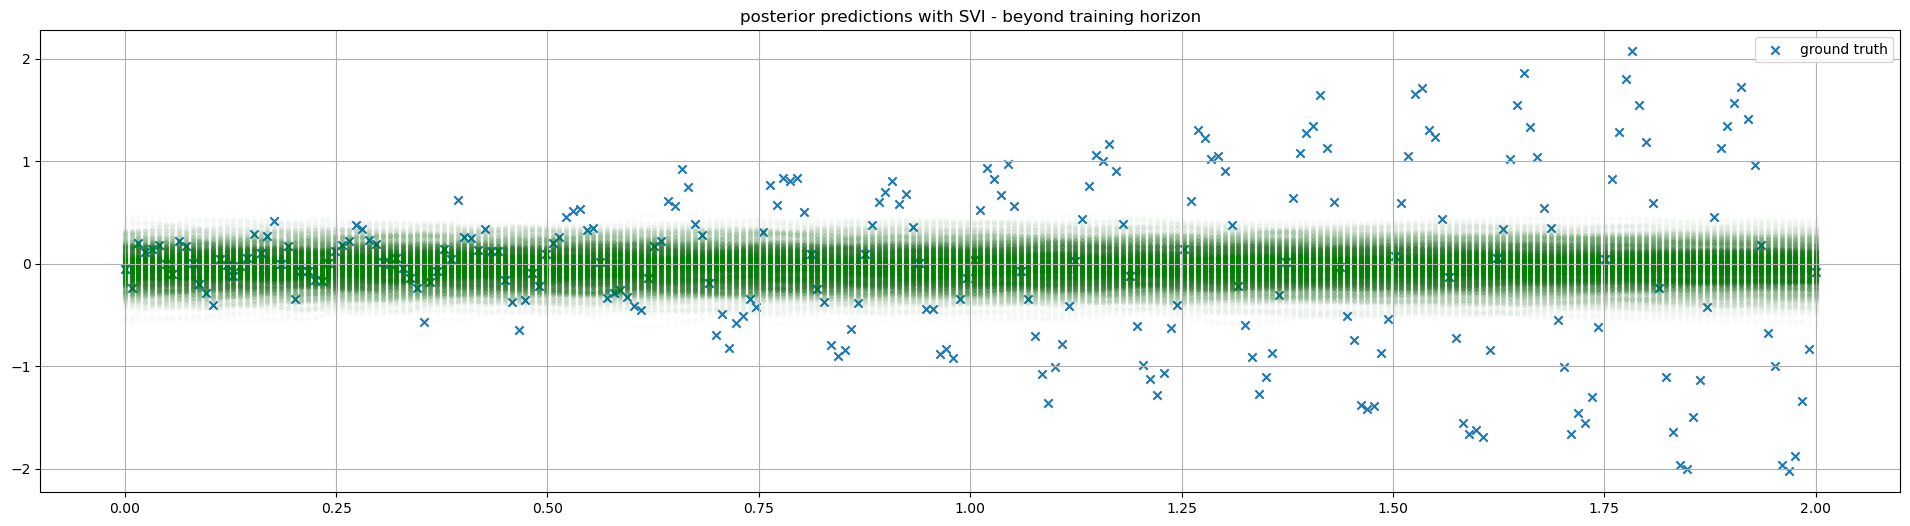

In [17]:
fig, ax = plt.subplots(figsize=(24,6))

ax.scatter(X_new.detach().cpu(),y_new.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior predictions with SVI - beyond training horizon')
for s in range(N_SAMPLES):
    ax.scatter(X_new.cpu(), y_preds_new[:,s].detach().cpu(), alpha=0.01, color='green', marker='.')
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 30px; color: black; font-weight: bold;">
3 : MCMC posterior sampling
</div>

In [18]:
# reset the Store parameters
pyro.clear_param_store()

In [19]:
# STEP 1 : define the NUTS kernel - takes the generative model itself.
nuts_kernel = NUTS(
    model=model,
    jit_compile=True, # True for speed, False for debugging
)

In [20]:
# STEP 2 : define a MCMC sampler with the above kernel
# does NOT use the model. This is merely the executor of the MCMCKernel
N_MCMC_SAMPLES = 10
N_BURNIN = 30

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=4,  # multi chain requires some work in a Jupyter notebook - see code !
    initial_params=None
)

Warmup [1]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/40 [00:00, ?it/s]

Reconstruction

In [21]:
# STEP3 : run the sampler
MCMC_runner.run(X,y)

In [22]:
# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
diags = MCMC_runner.diagnostics()

# Extract all 'n_eff' tensors for example : number of effective samples from the Markov chains
n_eff_list = []
for rv_name, rv_diagnostics in diags.items():
    
    # We only care about n_eff for the parameters we are sampling (weights, biases, sigma)
    # Exclude auxiliary or internal diagnostics if they exist.
    if 'n_eff' in rv_diagnostics and rv_name not in ['_last_state', 'potential_energy']:
        
        # n_eff might be a tensor if the site is multidimensional (like a weight matrix)
        n_eff_tensor = rv_diagnostics['n_eff']
        
        # Flatten the tensor and add all its elements to our list
        n_eff_list.append(n_eff_tensor.flatten())

# Concatenate all n_eff tensors into a single 1D tensor
all_n_eff = torch.cat(n_eff_list)

# Compute the average and minimum ESS
average_n_eff = all_n_eff.mean().item()
min_n_eff = all_n_eff.min().item()

print(f"Total number of stochastic parameters analyzed: {len(all_n_eff)}")
print(f"Overall Average Effective Sample Size (ESS): {average_n_eff:.2f}")
print(f"Minimum Effective Sample Size (ESS): {min_n_eff:.2f}")

Total number of stochastic parameters analyzed: 4322
Overall Average Effective Sample Size (ESS): 2.39
Minimum Effective Sample Size (ESS): 2.11


In [23]:
# extract samples
mcmc_samples = MCMC_runner.get_samples()

# instantiate the predictive with the model and the samples
predictive = Predictive(model, mcmc_samples)

# reconstruction
preds = predictive(X)

# The 'observations' key holds the predictive samples
y_mcmc_samples = preds['observations'] # Shape will be (num_samples, len(X))

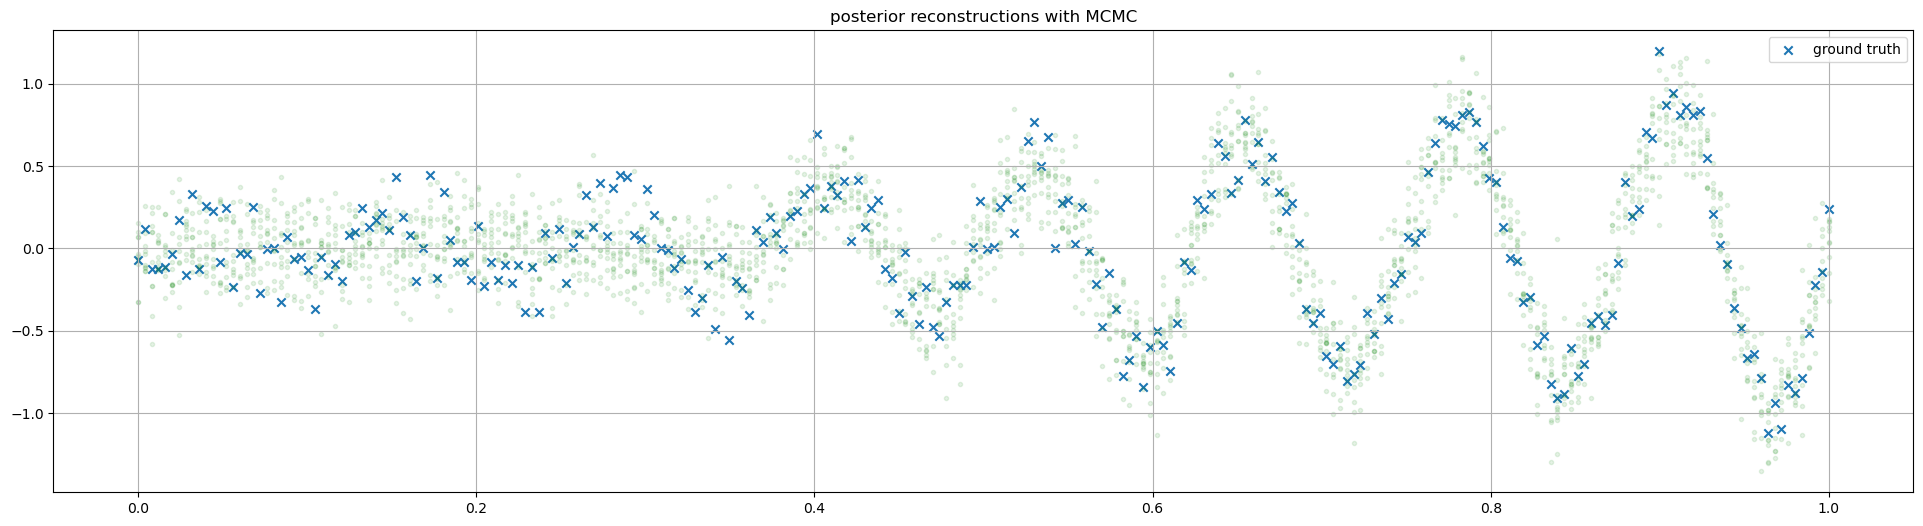

In [ ]:
fig, ax = plt.subplots(figsize=(24,6))

ax.scatter(X.detach().cpu(),y.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior reconstructions with MCMC')
for s in range(N_MCMC_SAMPLES):
    ax.scatter(X.cpu(), y_mcmc_samples[s,:].detach().cpu(), alpha=0.3, color='green', marker='.')
plt.show()

Forecast

In [25]:
# New starting points X_new
X_new = torch.linspace(0.0,2.0, steps=N_POINTS)
y_new = target_function(X_new) + torch.randn(N_POINTS)*noise

# need to re-instantiate the kernel as it is compiled with jit_compile=True
nuts_kernel = NUTS(
    model=model,
    jit_compile=True, # True for speed, False for debugging
)

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=4,  # multi chain requires some work in a Jupyter notebook - see code !
    initial_params=None
)

MCMC_runner.run(X_new,y_new)

Warmup [1]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/40 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/40 [00:00, ?it/s]

In [26]:
# extract samples
mcmc_samples_new = MCMC_runner.get_samples()

# instantiate the predictive with the model and the samples
predictive = Predictive(model, mcmc_samples_new)

# reconstruction
preds = predictive(X_new)

# The 'observations' key holds the predictive samples
y_mcmc_samples_new = preds['observations'] # Shape will be (num_samples, len(X))

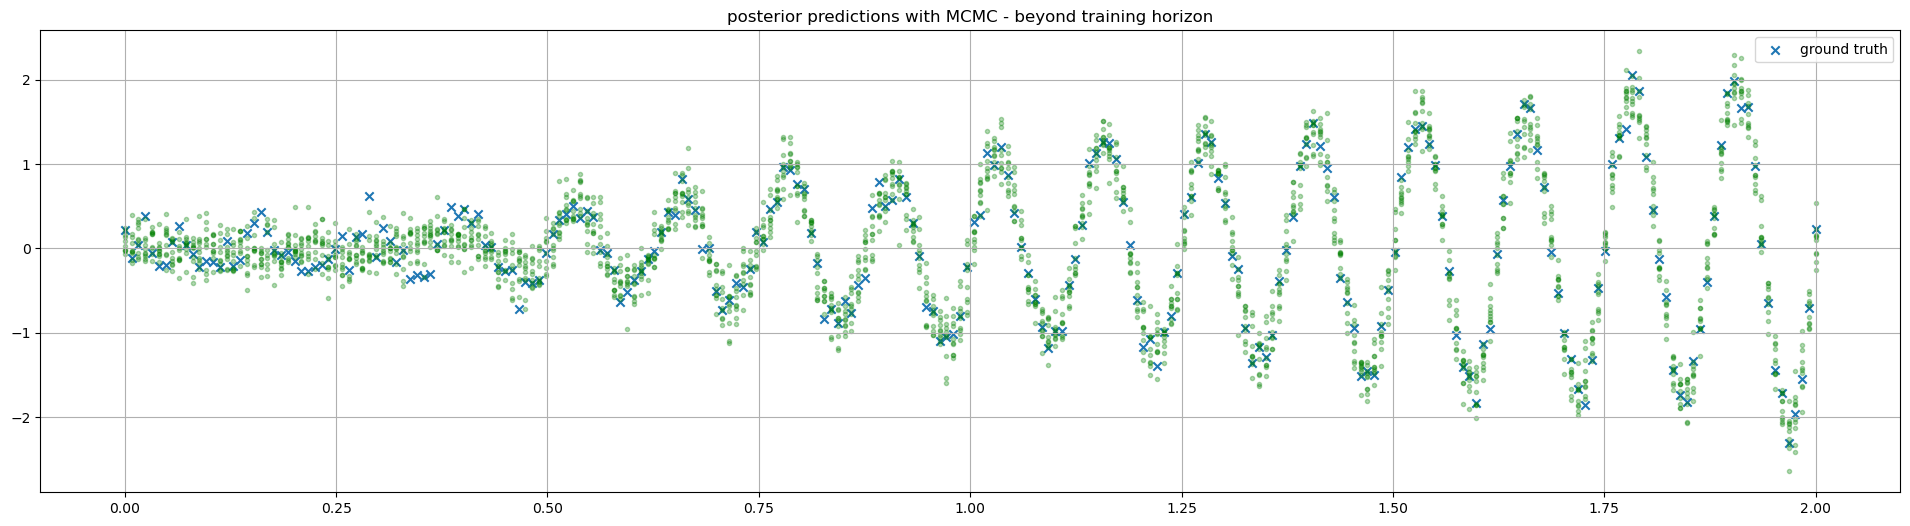

In [28]:
fig, ax = plt.subplots(figsize=(24,6))

ax.scatter(X_new.detach().cpu(),y_new.detach().cpu(), marker='x', label='ground truth')
ax.grid()
ax.legend()
ax.set_title(f'posterior predictions with MCMC - beyond training horizon')
for s in range(N_MCMC_SAMPLES):
    ax.scatter(X_new.cpu(), y_mcmc_samples_new[s,:].detach().cpu(), alpha=0.3, color='green', marker='.')
plt.show()